# Aufgabe 2: Adaptiver Medianfilter
Der Medianfilter aus der vorangegangenen Aufgabe eignet sich besonders, um *Salt-and-Pepper-Rauschen* zu beseitigen.
Scharfe Kanten werden zwar erhalten, Ecken jedoch gestört.
Eine Erweiterung, die noch spezieller auf die Rauschelimination ausgerichtet ist und dabei Ecken weniger beschädigen soll, ist der *adaptive Medianfilter*.

Dabei werden nicht nur Median $z_{med}$, sondern auch minimaler $z_{min}$ und maximaler Grauwert $z_{max}$ sowie der aktuelle Grauwert $z_{xy}$ eines Fensters berücksichtigt.
Folgender Algorithmus wird angewendet:

```
Level A:
   A1 = zmed - zmin
   A2 = zmed - zmax
   If A1 > 0 and A2 < 0, Goto Level B
   Else increase the window size
   If window size < Smax repeat Level A
   Else output zmed
Level B:
   B1 = zxy - zmin
   B2 = zxy - zmax
   If B1 > 0 and B2 < 0 output zxy
   Else output zmed
```

In Stufe A wird sichergestellt, dass der Median selbst kein Minimum oder Maximum im aktuellen Fenster ist, da dies dazu führen würde, ein verrauschtes Pixel zu vervielfältigen.
In Stufe B wird sichergestellt, dass der Median nur angewendet wird, um solche verrauschten Pixel zu eliminieren.

Implementieren Sie einen adaptiven Medianfilter!
Für stark verrauschte Bilder empfiehlt sich auch eine mehrfache Anwendung dieses Filters.

## 0. Pfade, Pakete etc.

In [1]:
import glob
import urllib.request

%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import imageio
import numpy as np
import math

In [2]:
# image_filter = 'Bilder/*.jpg'
# image_filter = 'Bilder/Aerial.jpg'
image_filter = 'Bilder/SEM.jpg'

## 1. Definition des Filters
Zuerst wird die maximale Größe der Maske definiert.

In [3]:
w = 3
Smax = 5

Hier benötigen wir wieder die Funktionen `max_filter`, `min_filter`, `median_filter` aus der vorherigen Aufgabe.

In [4]:
# max_filter = lambda g: np.max(g)
# min_filter = lambda g: np.min(g)
# median_filter = lambda g: np.median(g)

min_filter = lambda g: sorted(np.array(g).flatten().tolist())[0]
max_filter = lambda g: sorted(np.array(g).flatten().tolist())[g.shape[0]**2-1]
median_filter = lambda g: sorted(np.array(g).flatten().tolist())[(g.shape[0]**2+1)//2-1]

## 2. Laden des Bildes

In [5]:
image_path = np.random.choice(glob.glob(image_filter))
image = imageio.imread(image_path)

Für diese Aufgabe ist es wichtig, das Bild im Fließkommaformat vorliegen zu haben. Andernfalls kann der Median nicht immer korrekt berechet werden. Konvertieren sie `image` zu einer geeigneten Repräsentation:

In [6]:
image=image.astype(float)
image.shape

(298, 252)

# 3. Verrauschen des Bildes
Um ein realistisches Szenario zu simulieren, wird das Bild nun mit Salt-and-Pepper-Rauschen versehen:

In [7]:
image_noisy = np.copy(image)
for _ in range(100):
    index = tuple([np.random.randint(0,i) for i in image.shape])
    image_noisy[index] = np.random.choice([0.0,1.0])
image_noisy

array([[ 26.,  26.,  26., ...,   6.,   4.,   3.],
       [ 26.,  26.,  26., ...,   6.,   3.,   1.],
       [ 26.,  26.,  26., ...,   4.,   1.,   0.],
       ...,
       [203., 194., 179., ...,   0.,   0.,   0.],
       [199., 207., 207., ...,   0.,   0.,   0.],
       [168., 175., 179., ...,   0.,   0.,   0.]])

## 4. Berechung des Filters
Definieren Sie eine Funktion `ex4_adaptive_median_filter`, die ein Bild übergeben bekommt und als Rückgabewert das gefilterte Bild liefert. Tipp: verwenden Sie die in 1. definierten Rangordnungsoperatoren.

In [8]:
def ex4_adaptive_median_filter(image,w):
    filtered_image = np.zeros_like(image)
    image_rows,image_cols = image.shape
    
    fil = np.zeros((w,w))
    fil_rows=fil_cols = w  
    
    fil_half_rows=fil_rows//2
    fil_half_col=fil_cols//2
    img=np.pad(image,((fil_half_rows,fil_half_rows),(fil_half_col,fil_half_col)),'edge')
    
    for i in range(image_rows):
        for j in range (image_cols):
            fil=img[i:i+fil_rows,j:j+fil_cols]
            
            max_pixel = max_filter(fil)
            min_pixel = min_filter(fil)
            med_pixel = median_filter(fil)
            
            if med_pixel > min_pixel and med_pixel < max_pixel:
                if image[i][j] > min_pixel and image[i][j] < max_pixel:
                    filtered_image[i][j] = image[i][j]
                else:
                    filtered_image[i][j] = med_pixel
            else:
                w += 2
                if w <= Smax:
                    ex4_adaptive_median_filter(image,w)                                       
                else:
                    filtered_image[i][j] = med_pixel   
                    
    return filtered_image 

Nun wird das gefilterte Bild mit Hilfe der Funktion berechnet:

In [9]:
filtered_image = ex4_adaptive_median_filter(image_noisy,w)
filtered_image

array([[  0.,  26.,  26., ...,   6.,   4.,   3.],
       [ 26.,  26.,  26., ...,   6.,   3.,   1.],
       [ 26.,  26.,  26., ...,   4.,   1.,   0.],
       ...,
       [203., 194., 179., ...,   0.,   0.,   0.],
       [199., 194., 183., ...,   0.,   0.,   0.],
       [175., 175., 179., ...,   0.,   0.,   0.]])

## 5. Darstellung
Um die Wirksamkeit des adaptiven Medianfilters zu überprüfen, stellen Sie `image`, `image_noisy` und `filtered_image` nebeneinander dar:

<IPython.core.display.Javascript object>


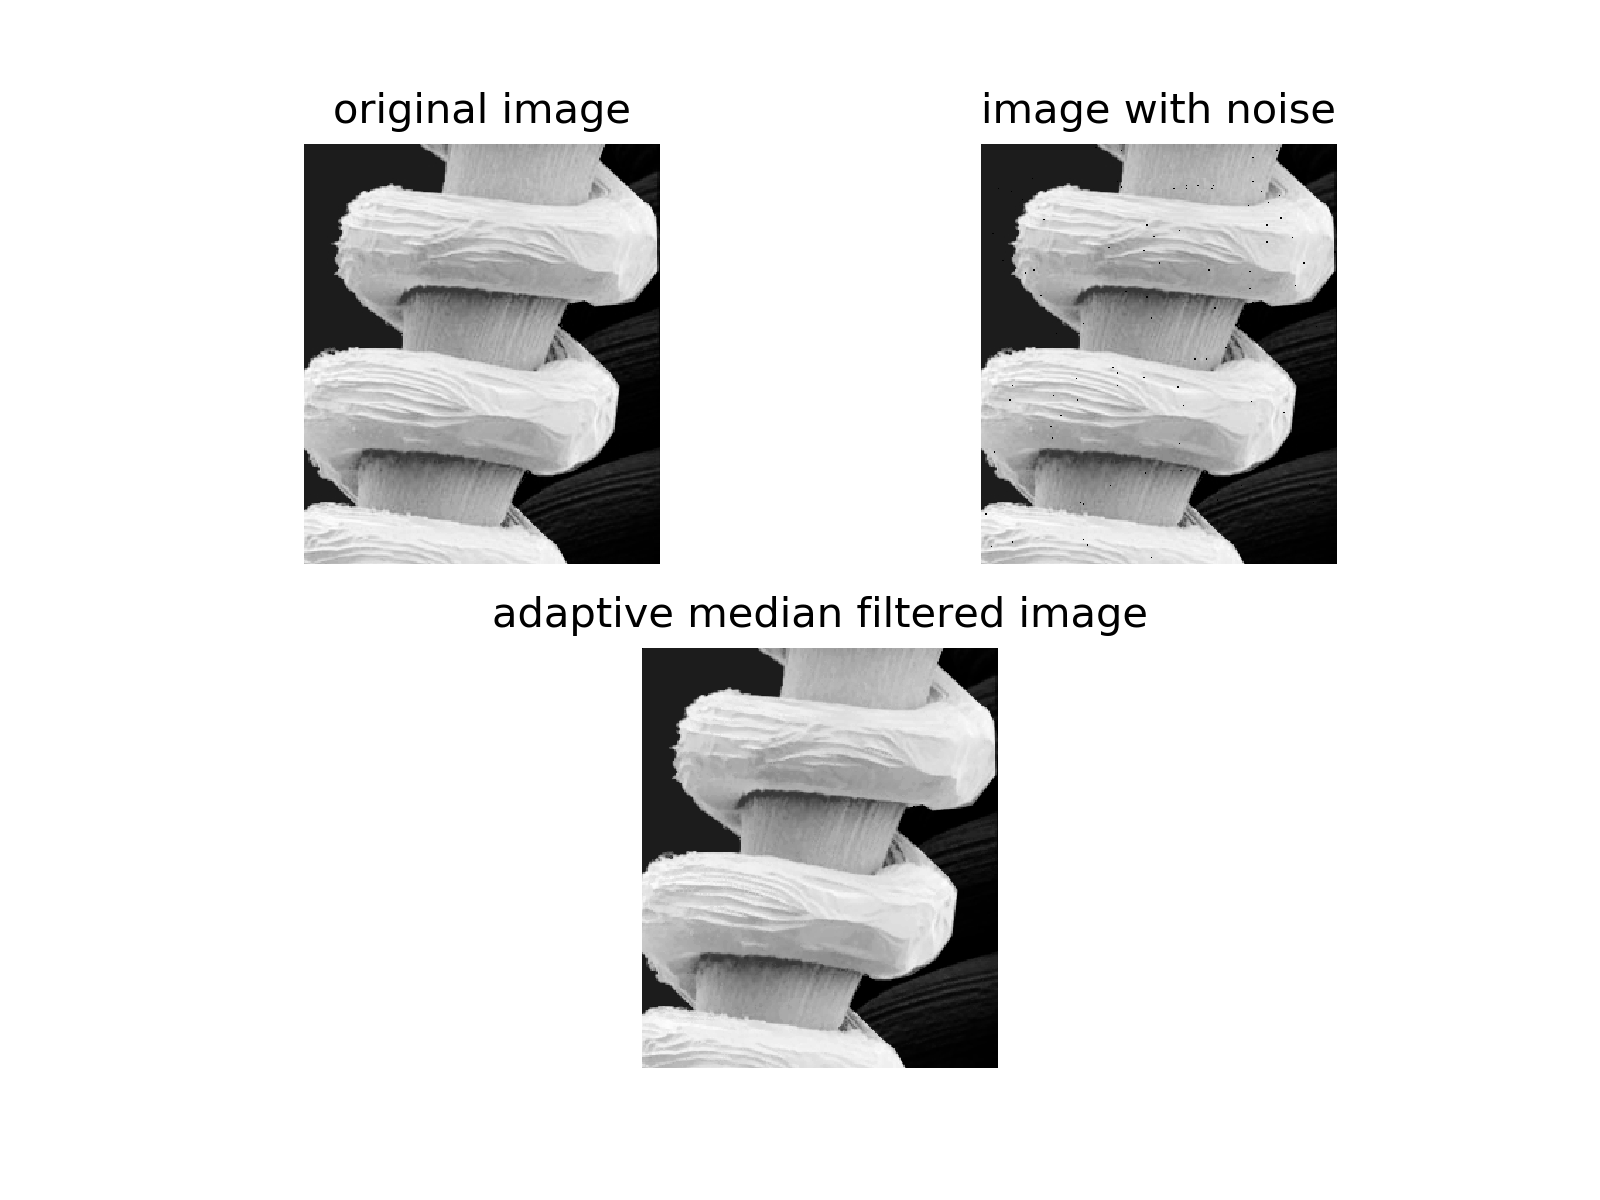

In [10]:
plt.figure('Image')

plt.subplot(2,2,1)
plt.title('original image')
plt.axis('off')
plt.imshow(image, cmap='gray')

plt.subplot(2,2,2)
plt.title('image with noise')
plt.axis('off')
plt.imshow(image_noisy, cmap='gray')

plt.subplot(2,1,2)
plt.title('adaptive median filtered image')
plt.axis('off')
plt.imshow(filtered_image, cmap='gray')

plt.show()